In [31]:
import os
import cv2
import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import ToTensor

import os
import cv2
import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import ToTensor

class FaceCompletionDataset(Dataset):
    def __init__(self, image_dir, block_size=(64, 64)):
        self.image_dir = image_dir
        self.block_size = block_size
        self.image_list = os.listdir(image_dir)

    def __len__(self):
        return len(self.image_list)
    
    def random_block_mask(self, image, block_size=(64, 64)):
        h, w, _ = image.shape
        x = random.randint(0, w - block_size[0])
        y = random.randint(0, h - block_size[1])
        mask = np.zeros((h, w), dtype=np.uint8)
        mask[y:y + block_size[1], x:x + block_size[0]] = 1
        masked_image = image.copy()
        noise = np.random.randint(0, 256, size=(block_size[1], block_size[0], 3), dtype=np.uint8)
        masked_image[y:y + block_size[1], x:x + block_size[0]] = noise
        return masked_image, mask
    
    def __getitem__(self, idx):
        image_path = os.path.join(self.image_dir, self.image_list[idx])
        image = cv2.imread(image_path)

        masked_image, mask = self.random_block_mask(image)

        image = ToTensor()(image)
        mask = ToTensor()(mask)
        masked_image = ToTensor()(masked_image)

        return image, mask, masked_image

    

image_dir = "preprocessed_images/"

celeba_dataset = FaceCompletionDataset(image_dir)


In [32]:
from torch.utils.data import DataLoader, random_split

# Assuming your_dataset is an instance of your Dataset class
train_size = int(0.8 * len(celeba_dataset))  # Use 80% of the dataset for training
val_size = len(celeba_dataset) - train_size

train_dataset, val_dataset = random_split(celeba_dataset, [train_size, val_size])

train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=4)
validation_dataloader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=4)

In [33]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [34]:
import torch
import torchvision.models as models
vgg19 = models.vgg19()
model_weights_path = 'vgg19-dcbb9e9d.pth'
vgg19.load_state_dict(torch.load(model_weights_path))
vgg19 = vgg19.to(device)
vgg19.eval()
 

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [35]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from collections import OrderedDict
from torch.nn import init
import numpy as np
import torch
import torch.nn as nn
import torch.nn as nn
import torchvision.models as models

class Generator(nn.Module):
    def __init__(self, in_channels=3):
        super(Generator, self).__init__()

        vgg19 = models.vgg19()
        model_weights_path = 'vgg19-dcbb9e9d.pth'
        vgg19.load_state_dict(torch.load(model_weights_path))
        vgg19 = vgg19.to(device)
        vgg19.eval()

        self.encoder = nn.Sequential(
            *list(vgg19.features.children())[:18],  # conv1 to pool3 of VGG-19
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0),
            nn.Flatten(),
            nn.Linear(4 * 8 * 8 * 256, 4096),
            nn.ReLU(inplace=True)
        )

        self.decoder = nn.Sequential(
            nn.Linear(4096, 8 * 8 * 256),
            nn.ReLU(inplace=True),
            nn.Unflatten(1, (256, 8, 8)),
            nn.ConvTranspose2d(256, 256, kernel_size=4, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=4, padding=0),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, in_channels, kernel_size=5, stride=1, padding=2)
        )

    def forward(self, x):
        x1 = self.encoder(x)
        x2 = self.decoder(x1)
        return torch.sigmoid(x2)

# refer from dcgan's discriminator
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=5, stride=2, padding=2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            
            nn.Conv2d(64, 128, kernel_size=5, stride=2, padding=2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            
            nn.Flatten(),
            nn.Linear(128 * 32 * 32, 1),
        )
    
    def forward(self, img):
        return self.model(img)

d_criterion=nn.BCEWithLogitsLoss()
def discriminator_loss(real_output, fake_output):
    real_loss = d_criterion(real_output, torch.ones_like(real_output).to(device))
    fake_loss = d_criterion(fake_output, torch.zeros_like(fake_output).to(device))
    total_loss = real_loss + fake_loss
    return total_loss

In [36]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils import spectral_norm as spectral_norm_fn
from torch.nn.utils import weight_norm as weight_norm_fn

class Parser(nn.Module):
    def __init__(self, config): # config is not used..
        super(Parser, self).__init__()
        self.input_dim = 3
        self.class_num = 17      # (16 components + backgorund)
        self.cnum = 64

        # 128 * 128 * cnum
        self.conv1_1 = gen_conv(self.input_dim, self.cnum, 7, 1, 1,)
        self.conv1_2 = gen_conv(self.cnum, self.cnum, 3, 2, 1)
        #--self.pool1

        # 64 * 64 * cnum
        self.conv2_1 = gen_conv(self.cnum, self.cnum * 2, 3, 1, 1)
        self.conv2_2 = gen_conv(self.cnum * 2, self.cnum * 2, 3, 2, 1)
        #--self.pool2

        # 32 * 32 * cnum
        self.conv3_1  = gen_conv(self.cnum * 2, self.cnum * 4, 3, 1, 1)
        self.conv3_2 = gen_conv(self.cnum * 4, self.cnum * 4, 3, 1, 1)
        self.conv3_3 = gen_conv(self.cnum * 4, self.cnum * 4, 3, 2, 1)
        #--self.pool3

        # 16 * 16 * cnum
        self.conv4_1 = gen_conv(self.cnum * 4, self.cnum * 8, 3, 1, 1)
        self.conv4_2 = gen_conv(self.cnum * 8, self.cnum * 8, 3, 1, 1)
        self.conv4_3 = gen_conv(self.cnum * 8, self.cnum * 8, 3, 2, 1)
        #--self.pool4

        # 8 * 8 * cnum
        self.conv5_1 = gen_conv(self.cnum * 8, self.cnum * 8, 3, 1, 1)
        self.conv5_2 = gen_conv(self.cnum * 8, self.cnum * 8, 3, 1, 1)
        self.conv5_3 = gen_conv(self.cnum * 8, self.cnum * 8, 3, 2, 1)
        #--self.pool5

        # 4 * 4 * cnum
        self.conv6_1 = gen_conv(self.cnum * 8, 4096, 3, 1, 1)


        #-- self.deconv6
        self.conv7_1  = gen_conv(4096, self.cnum * 8, 5, 1, 2)
        #-- dropout6

        # 8 * 8 * cnum
        #-- self.deconv7
        self.conv8_1 = gen_conv(self.cnum * 8, self.cnum * 8, 5, 1, 2)
        # -- dropout7

        # 16 * 16 * cnum
        #--self.deconv8
        self.conv9_1 = gen_conv(self.cnum * 8, self.cnum * 8, 5, 1, 2)
        # -- dropout8

        # 32 * 32 * cnum
        #-- self.deconv9
        self.conv10_1 = gen_conv(self.cnum * 8, self.cnum * 4, 5, 1, 2)
        # -- dropout9

        # 64 * 64 * cnum
        #--self.deconv10
        self.conv11_1 = gen_conv(self.cnum * 4, self.cnum * 2, 3, 1, 1)
        # -- dropout10

        # 128 * 128 * cnum
        #--self.deconv11
        self.conv12_1 = gen_conv(self.cnum * 2, self.cnum, 3, 1, 1)
        # -- dropout11

        # 128 * 128 * C+1 (FINAL)
        self.h_out = gen_conv(self.cnum, self.class_num, 3, 1, 1)

    def forward(self, x):

        # conv1
        x = self.conv1_1(x)
        x = self.conv1_2(x)
        #print(x.shape)
        #x = nn.MaxPool2d(x)


        # conv2
        x = self.conv2_1(x)
        x = self.conv2_2(x)
        #print(x.shape)
        #x = nn.MaxPool2d(x)


        # conv3
        x = self.conv3_1(x)
        x = self.conv3_2(x)
        x = self.conv3_3(x)
        #print(x.shape)
        #x = nn.MaxPool2d(x)

        # conv4
        x = self.conv4_1(x)
        x = self.conv4_2(x)
        x = self.conv4_3(x)
        #print(x.shape)
        #x = nn.MaxPool2d(x)

        # conv5
        x = self.conv5_1(x)
        x = self.conv5_2(x)
        x = self.conv5_3(x)
        #print(x.shape)
        #x = nn.MaxPool2d(x)

        # conv6
        x = self.conv6_1(x)
        #print(x.shape)

        # conv7
        x = F.interpolate(x, scale_factor=2, mode='nearest')
        x = self.conv7_1(x)
        #print(x.shape)
        x = F.dropout2d(x)

        # conv8
        x = F.interpolate(x, scale_factor=2, mode='nearest')
        x = self.conv8_1(x)
        #print(x.shape)

        # conv9
        x = F.interpolate(x, scale_factor=2, mode='nearest')
        x = self.conv9_1(x)
        #print(x.shape)

        # conv10
        x = F.interpolate(x, scale_factor=2, mode='nearest')
        x = self.conv10_1(x)
        #print(x.shape)

        # conv11
        x = F.interpolate(x, scale_factor=2, mode='nearest')
        x = self.conv11_1(x)
        #print(x.shape)

        # conv12
        #x = F.interpolate(x, scale_factor=2, mode='nearest')
        x = self.conv12_1(x)
        #print(x.shape)

        # h_out
        x_out = self.h_out(x)
        #print(x_out.shape)

        return x_out



def gen_conv(input_dim, output_dim, kernel_size=3, stride=1, padding=0, rate=1,
             activation='elu'):
    return Conv2dBlock(input_dim, output_dim, kernel_size, stride,
                       conv_padding=padding, dilation=rate,
                       activation=activation)


def dis_conv(input_dim, output_dim, kernel_size=5, stride=2, padding=0, rate=1,
             activation='lrelu'):
    return Conv2dBlock(input_dim, output_dim, kernel_size, stride,
                       conv_padding=padding, dilation=rate,
                       activation=activation)


class Conv2dBlock(nn.Module):
    def __init__(self, input_dim, output_dim, kernel_size, stride, padding=0,
                 conv_padding=0, dilation=1, name='conv', weight_norm='sn', norm='none',
                 activation='relu', pad_type='zero', transpose=False):
        super(Conv2dBlock, self).__init__()
        self.use_bias = True
        # initialize padding
        if pad_type == 'reflect':
            self.pad = nn.ReflectionPad2d(padding)
        elif pad_type == 'replicate':
            self.pad = nn.ReplicationPad2d(padding)
        elif pad_type == 'zero':
            self.pad = nn.ZeroPad2d(padding)
        elif pad_type == 'none':
            self.pad = None
        else:
            assert 0, "Unsupported padding type: {}".format(pad_type)

        # initialize normalization
        norm_dim = output_dim
        if norm == 'bn':
            self.norm = nn.BatchNorm2d(norm_dim)
        elif norm == 'in':
            self.norm = nn.InstanceNorm2d(norm_dim)
        elif norm == 'none':
            self.norm = None
        else:
            assert 0, "Unsupported normalization: {}".format(norm)

        if weight_norm == 'sn':
            self.weight_norm = spectral_norm_fn
        elif weight_norm == 'wn':
            self.weight_norm = weight_norm_fn
        elif weight_norm == 'none':
            self.weight_norm = None
        else:
            assert 0, "Unsupported normalization: {}".format(weight_norm)

        # initialize activation
        if activation == 'relu':
            self.activation = nn.ReLU(inplace=True)
        elif activation == 'elu':
            self.activation = nn.ELU(inplace=True)
        elif activation == 'lrelu':
            self.activation = nn.LeakyReLU(0.2, inplace=True)
        elif activation == 'prelu':
            self.activation = nn.PReLU()
        elif activation == 'selu':
            self.activation = nn.SELU(inplace=True)
        elif activation == 'tanh':
            self.activation = nn.Tanh()
        elif activation == 'none':
            self.activation = None
        else:
            assert 0, "Unsupported activation: {}".format(activation)

        # initialize convolution
        if transpose:
            self.conv = nn.ConvTranspose2d(input_dim, output_dim,
                                           kernel_size, stride,
                                           padding=conv_padding,
                                           output_padding=conv_padding,
                                           dilation=dilation,
                                           bias=self.use_bias)
        else:
            self.conv = nn.Conv2d(input_dim, output_dim, kernel_size, stride,
                                  padding=conv_padding, dilation=dilation,
                                  bias=self.use_bias)

        if self.weight_norm:
            self.conv = self.weight_norm(self.conv)

    def forward(self, x):
        if self.pad:
            x = self.conv(self.pad(x))
        else:
            x = self.conv(x)
        if self.norm:
            x = self.norm(x)
        if self.activation:
            x = self.activation(x)
        return x


In [37]:
#from utils.network_seg_contour import Parser
from argparse import ArgumentParser, Namespace
import torchvision.transforms as transforms
import torchvision.models as models
import torch
import yaml
def get_config(config_file):
    with open(config_file, 'r') as f:
        config = yaml.safe_load(f)
    return config
def get_args():
    parser = ArgumentParser()
    parser.add_argument('--config', type=str, default='config/seg_config.yaml', help="training configuration")
    parser.add_argument('--seed', type=int, default=2023, help='manual seed')

    try:
        args = parser.parse_args()
    except SystemExit:
        args = Namespace(config='config/seg_config.yaml', seed=2023)

    return args

args = get_args()
config = get_config(args.config)
netG = Parser(config)
def load_face_parsing_model(model_path):
    
    netG.load_state_dict(torch.load(model_path), strict=False)
    netG.eval()
    return netG

usage: ipykernel_launcher.py [-h] [--config CONFIG] [--seed SEED]
ipykernel_launcher.py: error: unrecognized arguments: -f /home/x1112373/.local/share/jupyter/runtime/kernel-8dd77cbc-7ab4-4c89-9ead-2da49a314a96.json


In [38]:


generator = Generator()

global_discriminator = Discriminator()
local_discriminator = Discriminator()

criterion = nn.BCELoss()
criterion_adv = nn.BCEWithLogitsLoss()
criterion_context = nn.L1Loss()

optimizer_generator = torch.optim.Adam(generator.parameters(), lr=0.0001) ## generate converge faster than discriminator
discriminator_optimizer =torch.optim.Adam(global_discriminator.parameters(), lr=0.0001)
criterion_perceptual = nn.L1Loss()

face_parsing_model = load_face_parsing_model('pretrained_model/parser_00100000.pt')
face_parsing_model = face_parsing_model.to(device)
criterion_parsing = nn.CrossEntropyLoss()



In [39]:
generator = generator.to(device)
discriminator_global = global_discriminator.to(device)
discriminator_local = local_discriminator.to(device)

In [40]:
from skimage.metrics import peak_signal_noise_ratio as psnr, structural_similarity as ssim

def evaluate_models(generator, discriminator_global, discriminator_local, dataloader, criterion_adv, criterion_context, criterion_perceptual, vgg19, lambda1, lambda2, lambda3):
    generator.eval()
    discriminator_global.eval()
    discriminator_local.eval()

    total_gen_loss = 0
    total_disc_global_loss = 0
    total_disc_local_loss = 0
    total_samples = 0

    with torch.no_grad():
        for i, (images, masks, masked_images) in enumerate(dataloader):
            if i == 0:
                print(i)
            images = images.to(device)
            masks = masks.to(device)
            masked_images = masked_images.to(device) 

            completed_images = generator(masked_images)
            parsed_images = face_parsing_model(images)
            parsed_completed_images = face_parsing_model(completed_images)
            loss_parsing = criterion_parsing(parsed_completed_images, torch.argmax(parsed_images, dim=1))
            
            expanded_masks = masks.expand_as(images)
            masked_completed_images = completed_images * expanded_masks
        
            local_real_output = local_discriminator(masked_images)
            local_fake_output = local_discriminator(masked_completed_images)
        
            global_real_output = global_discriminator(images)
            global_fake_output = global_discriminator(completed_images)


            loss_adv_global = discriminator_loss(global_real_output, global_fake_output)
            loss_adv_local = discriminator_loss(local_real_output, local_fake_output)
            loss_adv = loss_adv_global + loss_adv_local

            loss_context = criterion_context(completed_images * expanded_masks, images * expanded_masks)
 
            loss_perceptual = criterion_perceptual(vgg19(completed_images), vgg19(images))
            parsed_images = face_parsing_model(images)
            parsed_completed_images = face_parsing_model(completed_images)        
            loss_parsing = criterion_parsing(parsed_completed_images, torch.argmax(parsed_images, dim=1))

            
            loss_generator = lambda1 * loss_adv + lambda2 * loss_context + loss_perceptual + lambda3 * loss_parsing
            
            total_gen_loss += loss_generator.item()
            total_disc_global_loss += loss_adv_global.item()
            total_disc_local_loss += loss_adv_local.item()
            total_samples += images.size(0)

    mean_gen_loss = total_gen_loss / total_samples
    mean_disc_global_loss = total_disc_global_loss / total_samples
    mean_disc_local_loss = total_disc_local_loss / total_samples

    return mean_gen_loss, mean_disc_global_loss, mean_disc_local_loss

def evaluate_model_external(model, dataloader):
    model.eval()
    total_psnr = 0
    total_ssim = 0
    total_samples = 0

    with torch.no_grad():
        for i, (images, masks, masked_images) in enumerate(dataloader):
            masked_images = masked_images.to(device) 
            completed_images = model(masked_images)
 
            for i in range(images.size(0)):
                image = images[i].cpu().numpy().transpose(1, 2, 0)
                completed_image = completed_images[i].cpu().numpy().transpose(1, 2, 0)

                total_psnr += psnr(image, completed_image)
                total_ssim += ssim(image, completed_image, multichannel=True, win_size=3, data_range=1)

            total_samples += images.size(0)

    return total_psnr / total_samples, total_ssim / total_samples



In [41]:
import copy
import pandas as pd
import matplotlib.pyplot as plt
def return_image_numpy(images, scale=False):
    if scale:
        completed_images_np = images[0].cpu().detach().numpy()
 
        completed_images_np = ((completed_images_np + 1) * 127.5)
        print(completed_images_np.shape)
        return completed_images_np.transpose(1, 2, 0)
    else:
        return images[0].detach().cpu().numpy().transpose(1, 2, 0)
save_path = './model/'

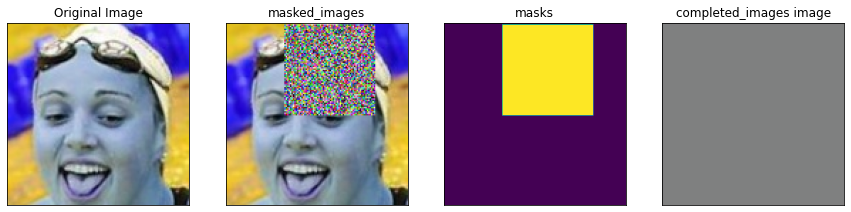

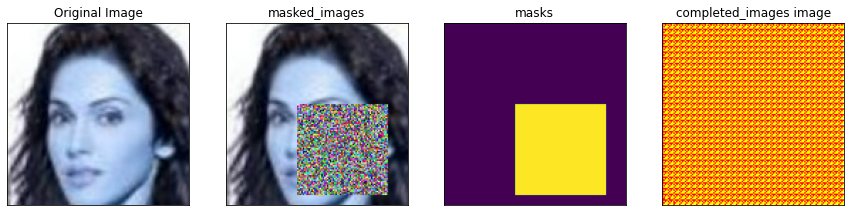

0
Epoch: 0, Validation Losses - Generator: 26.3341, Discriminator Global: 0.0000, Discriminator Local: 0.0873
Epoch: 0, Validation PSNR: 4.0927, SSIM: -0.1893


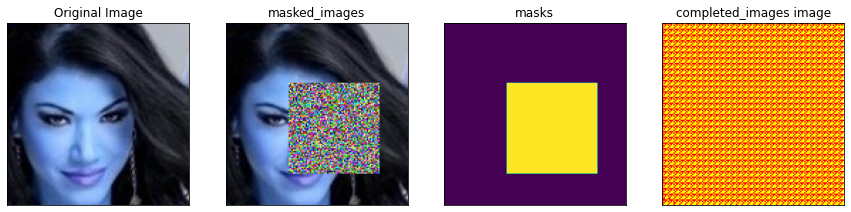

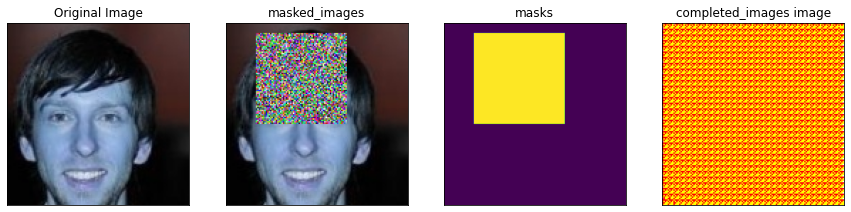

0
Epoch: 1, Validation Losses - Generator: 26.3348, Discriminator Global: 0.0000, Discriminator Local: 0.0873
Epoch: 1, Validation PSNR: 4.0927, SSIM: -0.1893


In [ ]:
import random
import pandas as pd
num_epochs = 30
best_loss = float('inf')
patience = 3
# Set the weights for the different losses
lambda1 = 300
lambda2 = 300
lambda3 = 0.005

result_df = pd.DataFrame(columns= ['epoch', 'step', 'val_gen_loss', 'val_disc_global_loss', 'val_disc_local_loss', 'val_psnr', 'val_ssim' ])
for epoch in range(num_epochs):
    for i, (images, masks, masked_images) in enumerate(train_dataloader):
        # Resize the images and masks to a consistent size
        
        images = images.to(device)
        masked_images = masked_images.to(device)
        masks = masks.to(device)
        # Train the generator and discriminators using the images and masks
        # Implement the training algorithm according to the paper
    
        # 1. Generate completed images using the generator (Completion Network)

        completed_images = generator(masked_images)
 
        # 2. Compute the adversarial loss for the generator using the global and local discriminators
#         real_labels = torch.ones(images.size(0), 1).to(device)
#         fake_labels = torch.zeros(images.size(0), 1).to(device)
 
        # Expand the real and fake labels to match the output size of the discriminators
#         real_labels_expanded = real_labels.view(real_labels.size(0), 1, 1, 1).expand_as(global_real_output).clone()
#         fake_labels_expanded = fake_labels.view(fake_labels.size(0), 1, 1, 1).expand_as(global_fake_output).clone()
        
#         real_labels_expanded = real_labels_expanded.to(device)
#         fake_labels_expanded = fake_labels_expanded.to(device)
        
#         loss_adv_global = criterion_adv(global_real_output, real_labels_expanded) + criterion_adv(global_fake_output, fake_labels_expanded)
#         loss_adv_local = criterion_adv(local_real_output, real_labels_expanded) + criterion_adv(local_fake_output, fake_labels_expanded)
#         loss_adv = loss_adv_global + loss_adv_local
        
        # 3. Compute the contextual loss by measuring the L1 distance between the original and completed images
        expanded_masks = masks.expand_as(images)
        masked_completed_images = completed_images * expanded_masks
        
        local_real_output = local_discriminator(masked_images)
        local_fake_output = local_discriminator(masked_completed_images)
        
        global_real_output = global_discriminator(images)
        global_fake_output = global_discriminator(completed_images)
        
        loss_adv_global = discriminator_loss(global_real_output, global_fake_output)
        loss_adv_local = discriminator_loss(local_real_output, local_fake_output)
        loss_adv = loss_adv_global + loss_adv_local

        
        loss_context = criterion_context(completed_images * expanded_masks, images * expanded_masks)

        # 4. Compute the perceptual loss using the VGG-16 network
        # Resize completed_images and images to be compatible with VGG-16
#         vgg_completed_images = upsample_for_vgg(completed_images)
#         vgg_images = upsample_for_vgg(images)

        loss_perceptual = criterion_perceptual(vgg19(completed_images), vgg19(images))
        parsed_images = face_parsing_model(images)
        parsed_completed_images = face_parsing_model(completed_images)
        loss_parsing = criterion_parsing(parsed_completed_images, torch.argmax(parsed_images, dim=1))

        # 5. Update the weights of the generator using the combined loss (adversarial, contextual, and perceptual losses)
        loss_generator = lambda1 * loss_adv + lambda2 * loss_context + loss_perceptual + lambda3 * loss_parsing

        optimizer_generator.zero_grad()
        loss_generator.backward(retain_graph=True)
        optimizer_generator.step()

        # 6. Update the weights of the global and local discriminators using their respective adversarial losses
        discriminator_optimizer.zero_grad()
        loss_adv.backward()

        discriminator_optimizer.step()
        if i % 10000 == 0:
            fig, axs = plt.subplots(1, 4, figsize=(15, 5))
            axs[0].imshow(return_image_numpy(images))
            axs[0].set_title("Original Image")
            axs[1].imshow(return_image_numpy(masked_images))
            axs[1].set_title("masked_images")
            axs[2].imshow(return_image_numpy(masks))
            axs[2].set_title("masks")
            axs[3].imshow(return_image_numpy(completed_images))
            axs[3].set_title("completed_images image")

            for ax in axs:
                ax.set_xticks([])
                ax.set_yticks([])

    plt.show()
    
    # Evaluation
    # Inside your training loop, after each epoch
    val_gen_loss, val_disc_global_loss, val_disc_local_loss = evaluate_models(generator, discriminator_global, discriminator_local, validation_dataloader, criterion_adv, criterion_context, criterion_perceptual, vgg19, lambda1, lambda2, lambda3)
    print(f"Epoch: {epoch}, Validation Losses - Generator: {val_gen_loss:.4f}, Discriminator Global: {val_disc_global_loss:.4f}, Discriminator Local: {val_disc_local_loss:.4f}")
    val_psnr, val_ssim = evaluate_model_external(generator, validation_dataloader)
    print(f"Epoch: {epoch}, Validation PSNR: {val_psnr:.4f}, SSIM: {val_ssim:.4f}")
    result_df.append({'epoch': epoch, 'step': i, 'val_gen_loss': val_gen_loss, 'val_disc_global_loss': val_disc_global_loss, 'val_disc_local_loss': val_disc_local_loss, 'val_psnr': val_psnr, 'val_ssim': val_ssim}, ignore_index=True)
    result_df.to_csv('result_df.csv') 
    # Update the best loss and save the model if necessary
    
    if val_gen_loss < best_loss:
        best_loss = val_gen_loss
        best_generator = copy.deepcopy(generator.state_dict())
        best_discriminator_global = copy.deepcopy(discriminator_global.state_dict())
        best_discriminator_local = copy.deepcopy(discriminator_local.state_dict())
        # Save the best models
        torch.save(best_generator, os.path.join(save_path, 'generator.pth'))
        torch.save(best_discriminator_global, os.path.join(save_path, 'discriminator_global.pth'))
        torch.save(best_discriminator_local, os.path.join(save_path, 'discriminator_local.pth'))

        counter = 0
    else:
        counter += 1

    # Check for early stopping
    if counter >= patience:
        print("Early stopping triggered.")
        break


In [16]:
val_gen_loss, val_disc_global_loss, val_disc_local_loss = evaluate_models(generator, discriminator_global, discriminator_local, validation_dataloader, criterion_adv, criterion_context, criterion_perceptual, vgg19, lambda1, lambda2, lambda3)
print(f"Epoch: {epoch}, Validation Losses - Generator: {val_gen_loss:.4f}, Discriminator Global: {val_disc_global_loss:.4f}, Discriminator Local: {val_disc_local_loss:.4f}")
val_psnr, val_ssim = evaluate_model_external(generator, validation_dataloader)
print(f"Epoch: {epoch}, Validation PSNR: {val_psnr:.4f}, SSIM: {val_ssim:.4f}")
result_df.append({'epoch': epoch, 'step': i, 'val_gen_loss': val_gen_loss, 'val_disc_global_loss': val_disc_global_loss, 'val_disc_local_loss': val_disc_local_loss, 'val_psnr': val_psnr, 'val_ssim': val_ssim}, ignore_index=True)
result_df.to_csv('result_df.csv') 
# Update the best loss and save the model if necessary

if val_gen_loss < best_loss:
    best_loss = val_gen_loss
    best_generator = copy.deepcopy(generator.state_dict())
    best_discriminator_global = copy.deepcopy(discriminator_global.state_dict())
    best_discriminator_local = copy.deepcopy(discriminator_local.state_dict())
    # Save the best models
    torch.save(best_generator, os.path.join(save_path, 'generator.pth'))
    torch.save(best_discriminator_global, os.path.join(save_path, 'discriminator_global.pth'))
    torch.save(best_discriminator_local, os.path.join(save_path, 'discriminator_local.pth'))

    counter = 0
else:
    counter += 1

# Check for early stopping
if counter >= patience:
    print("Early stopping triggered.")
    break

0
Epoch: 0, Validation Losses - Generator: 26.1008, Discriminator Global: 0.0000, Discriminator Local: 0.0865
Epoch: 0, Validation PSNR: 4.0945, SSIM: -0.1650


SyntaxError: 'break' outside loop (1112679745.py, line 26)

In [ ]:
result_df.to_csv('result_df.csv')

In [ ]:
# import cv2
# import matplotlib.pyplot as plt
# # Display the original image, mask, and masked image
# fig, axs = plt.subplots(1, 4, figsize=(15, 5))
# axs[0].imshow(return_image_numpy(images))
# axs[0].set_title("Original Image")
# axs[1].imshow(return_image_numpy(masked_images))
# axs[1].set_title("masked_images")
# axs[2].imshow(return_image_numpy(masks))
# axs[2].set_title("masks")
# axs[3].imshow(return_image_numpy(completed_images))
# axs[3].set_title("completed_images image")

# for ax in axs:
#     ax.set_xticks([])
#     ax.set_yticks([])


#images, masks, masked_images